# Project Final Report

### Due: Midnight on April 27 (2-hour grace period) — 50 points  

### No late submissions will be accepted.




In [24]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns
import matplotlib.pyplot as plt



# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict, KFold
# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42
# combined_results = pd.DataFrame()     # this is read in after so commenting out here for Stability
# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.2f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


# Format Time for GridSearchCV
def format_time(seconds):
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.4f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"




## Overview

Your final submission consists of **three components**:



---

### 1. Final Report Notebook [40 pts]

Complete all sections of this notebook to document your final decisions, results, and broader context.

- **Part A**: Select the single best model from your Milestone 2 experiments. Now that you’ve finalized your model, revisit your decisions from Milestones 1 and 2. Are there any steps you would change—such as cleaning, feature engineering, or model evaluation—given what you now know?

- **Part B**: Write a technical report following standard conventions, for example:
  - [CMU guide to structure](https://www.stat.cmu.edu/~brian/701/notes/paper-structure.pdf)
  - [Data science report example](https://www.projectpro.io/article/data-science-project-report/620)
  - The Checklist given in this week's Blackboard Lesson (essentially the same as in HOML).
    
  Your audience here is technically literate but unfamiliar with your work—like your manager or other data scientists. Be clear, precise, and include both code (for illustration), charts/plots/illustrations, and explanation of what you discovered and your reasoning process. 

The idea here is that Part A would be a repository of the most important code, for further work to come, and Part B is
the technical report which summarizes your project for the data science group at your company. Do NOT assume that readers of Part B are intimately familiar with Part A; provide code for illustration as needed, but not to run.

Submit this notebook as a group via your team leader’s Gradescope account.

---

### 2. PowerPoint Presentation [10 pts]

Create a 10–15 minute presentation designed for a general audience (e.g., sales or marketing team).

- Prepare 8–12 slides, following the general outline of the sections of Part B. 
- Focus on storytelling, visuals (plots and illustrations), and clear, simplified language. No code!
- Use any presentation tool you like, but upload a PDF version.
- List all team members on the first slide.

Submit as a group via your team leader’s Gradescope account.

---

### 3. Individual Assessment

Each team member must complete the Individual Assessment Form (same as in Milestone 1), sign it, and upload it via their own Gradescope account.

---

## Submission Checklist

-  Final Report Notebook — Team leader submission
-  PDF Slides — Team leader submission
-  Individual Assessment Form — Each member submits their own


____

____

## Part A: Final Model and Design Reassessment [10 pts]

In this part, you will finalize your best-performing model and revisit earlier decisions to determine if any should be revised in light of your complete modeling workflow. You’ll also consolidate and present the key code used to run your model on the preprocessed dataset, with thoughtful documentation of your reasoning.

**Requirements:**

- Reconsider **at least one decision from Milestone 1** (e.g., preprocessing, feature engineering, or encoding). Explain whether you would keep or revise that decision now that you know which model performs best. Justify your reasoning.
  
- Reconsider **at least one decision from Milestone 2** (e.g., model evaluation, cross-validation strategy, or feature selection). Again, explain whether you would keep or revise your original decision, and why.

- Below, include all code necessary to **run your final model** on the processed dataset. This section should be a clean, readable summary of the most important steps from Milestones 1 and 2, adapted as needed to fit your final model choice and your reconsiderations as just described. 

- Use Markdown cells and inline comments to explain the structure of the code clearly but concisely. The goal is to make your reasoning and process easy to follow for instructors and reviewers.

> Remember: You are not required to change your earlier choices, but you *are* required to reflect on them and justify your final decisions.


### **Import Dataset**

In [25]:
# Original DataFrame from part 1
milestone_1_df = pd.read_csv('Datasets_Results/milestone_1_df.csv')

# Baseline DF used for Baseline Modeling
baseline_df = pd.read_csv('Datasets_Results/baseline_df.csv')

# Final Feature Engineering DFs
feature_engineering_df_no_log = pd.read_csv('Datasets_Results/feature_engineering_df_no_log.csv')
feature_engineering_df_log = pd.read_csv('Datasets_Results/feature_engineering_df_log.csv')

# Copy of Feature Engineering DFs for input of Feature Selection
selected_features_df = pd.read_csv('Datasets_Results/selected_features_df.csv')

# Copy of Feature Engineering DFs used for Fine Tuning 
fine_tuning_df = pd.read_csv('Datasets_Results/fine_tuning_df.csv')

# =============
#  Results DFs 
# =============

# Combined Results Global DF that Subsequent Results are appended to 
combined_results_df = pd.read_csv('Datasets_Results/combined_results.csv')

# Copy of Combined Results with Extra Columns for Plotting in Write up
combined_results_part4 = pd.read_csv('Datasets_Results/combined_results_part4.csv')

### **Prelude: Functions Definitions**

#### **Profile Dataset**

This function was used to quickly profile the number of null and unique values within a dataset throughout our Milestone 1 and Milestone 2 notebooks. We’ve imported it here to verify that the relevant datasets were saved correctly, and because we specifically reference its results in our subsequent report.

In [26]:
# ========================================================================================
# This is meant to consolidate the 'show_null_counts_features' function from before with 
# another with 'value' and 'unique' counts later on in this analysis. 
# ========================================================================================

def profile_dataset(df):
    # Identify feature types
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')

    # Build a summary DataFrame
    summary = pd.DataFrame({
        'Feature': df.columns,
        'Type': feature_types.values,
        'Null Values': df.isnull().sum().values,
        'Null %': (df.isnull().mean() * 100).round(2).values,
        'Count (Non-Null)': df.count().values,
        'Unique Values': df.nunique().values
    })

    # Sort Values in Summary by % of null values
    summary = summary.sort_values(by='Null %', ascending=False).reset_index(drop=True)

    # Add dataset shape info above the table
    print(f"This dataset contain {df.shape[0]} rows")
    print(f"This dataset contain {df.shape[1]} columns")

    # Display the summary
    return summary

#### **Train Test Split**

Function to train test split the data provided a dataframe and a target column

In [27]:
def train_test_split_data(df, target_col):
    X = df.drop(columns=target_col)
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test 

#### **Standardization Function**

This function applies the StandardScaler from scikit-learn to numerical features, excluding categorical columns and those that have been one-hot encoded (i.e., columns with two or fewer unique values). It is called within functions like run_model() to ensure that datasets are properly scaled when required.

In [28]:
def standardize_features_train_and_test(X_train, X_test=None, target_column=None, debug=False, return_scaler=False):
    """
    Standardize numerical features in either a single DataFrame or in X_train/X_test split.

    Parameters:
    - X_train: DataFrame to scale (or the only one, for legacy use)
    - X_test: Optional second DataFrame (for train/test split)
    - target_column: Column to exclude from scaling
    - debug: Print details
    - return_scaler: Whether to return the fitted scaler

    Returns:
    - Scaled X_train (or single df), optional X_test, optional scaler
    """
    legacy_mode = X_test is None  # True if using legacy single-DF mode

    # In legacy mode, treat input as single DataFrame
    if legacy_mode:
        df_scaled = X_train.copy()
        numeric_cols = df_scaled.select_dtypes(include='number').columns.tolist()

        if target_column in numeric_cols:
            numeric_cols.remove(target_column)

        numeric_cols_to_scale = [col for col in numeric_cols if df_scaled[col].nunique(dropna=True) > 2]

        if debug:
            print("Scaling columns:", numeric_cols_to_scale)

        scaler = StandardScaler()
        df_scaled[numeric_cols_to_scale] = scaler.fit_transform(df_scaled[numeric_cols_to_scale])

        if return_scaler:
            return df_scaled, None, scaler
        return df_scaled  # legacy-compatible

    # --- New version for X_train/X_test split ---
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy() if X_test is not None else None

    numeric_cols = X_train.select_dtypes(include='number').columns.tolist()
    if target_column and target_column in numeric_cols:
        numeric_cols.remove(target_column)

    numeric_cols_to_scale = [col for col in numeric_cols if X_train[col].nunique(dropna=True) > 2]

    if debug:
        print("Numeric columns to scale:", numeric_cols_to_scale)

    scaler = StandardScaler()
    X_train_scaled[numeric_cols_to_scale] = scaler.fit_transform(X_train[numeric_cols_to_scale])

    if X_test_scaled is not None:
        X_test_scaled = X_test_scaled[X_train_scaled.columns]
        X_test_scaled[numeric_cols_to_scale] = scaler.transform(X_test_scaled[numeric_cols_to_scale])

    if return_scaler and X_test is not None: 
        return X_train_scaled, X_test_scaled, scaler

    if X_test is not None: 
        return X_train_scaled, X_test_scaled, None

    # Always return 3 values (legacy call with just one dataset)
    if return_scaler:
        return X_train_scaled, None, scaler

    return X_train_scaled, None, None


In [29]:
# ===================================================
# Standardize Numeric Features

# This uses the global df_clean_numeric found 
# earlier which filters out 'id' and 'flag' variables
# ===================================================

def standardize_features(df, target_column=None, debug=False, return_scaler=False):
    df_scaled = df.copy()
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    """ removed hardcoded filter
    numeric_cols1 = [col for col in numeric_cols 
                     if 'landuse' not in col.lower() and 
                        'flag' not in col.lower() and 
                        'id' not in col.lower() and
                        'county_name' not in col.lower()]
    """

    if target_column in numeric_cols:
        numeric_cols.remove(target_column)

    # Step 4: Further exclude binary (0/1) columns
    numeric_cols_to_scale = [
        col for col in numeric_cols
        if df[col].nunique(dropna=True) > 2
    ]

    # DEBUG
    if debug:    
        print("Numeric columns before filtering:", numeric_cols)
        print("Numeric columns after filtering:", numeric_cols_to_scale)    

    scaler = StandardScaler()
    df_scaled[numeric_cols_to_scale] = scaler.fit_transform(df_scaled[numeric_cols_to_scale])
    
    if return_scaler:
        return df_scaled, scaler
    
    return df_scaled


#### **Run Model Function**

This function served as a basis for running the models in each section of our report. It was modified from its original version in Module 3 materials and edited to include the following: 

- **concat_results:** A boolean parameter meant to append results to our global combined_results dataframe. We subsequently used this dataframe to store the results of each of the models throughout the course of the excersice. 

- **plot_pred:** A boolean parameter meant to plot the predictions of the trained model against their actual values in the training (or optional: Test set). This is meant to evaluate how the model is performing. 

- **target_is_logged:** Another boolean parameter meant to change the Cross Validation strategy in case the target variable was logged.

In [30]:
# New version with test data and scaling:
def run_model(
    model,
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    n_repeats=5,
    n_jobs=-1,
    concat_results=False,
    run_comment=None,
    target_is_logged=False,
    plot_pred=False,
    return_scaler=False,
    **model_params
):
    global combined_results

    # Scale both training and test data
    X_train_scaled, X_test_scaled, scaler = standardize_features_train_and_test(
        X_train=X_train,
        X_test=X_test,
        target_column=None,
        return_scaler=True
    )

    model_instance = model(**model_params) if isinstance(model, type) else model
    model_name = model.__name__ if isinstance(model, type) else model.__class__.__name__

    # --- Cross-validation & training ---
    if target_is_logged:
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        rmse_scores = []

        for train_idx, val_idx in kf.split(X_train_scaled):
            X_tr = X_train_scaled.iloc[train_idx]
            X_val = X_train_scaled.iloc[val_idx]
            y_tr = y_train.iloc[train_idx]
            y_val = y_train.iloc[val_idx]

            model_instance.fit(X_tr, y_tr)
            preds_log = model_instance.predict(X_val)

            y_preds = np.expm1(preds_log)
            y_true = np.expm1(y_val)

            rmse_scores.append(root_mean_squared_error(y_true, y_preds))

        mean_CV_RMSE = np.mean(rmse_scores)
        std_CV_RMSE = np.std(rmse_scores)

        # Fit final model on full training set
        model_instance.fit(X_train_scaled, y_train)
        y_train_pred = np.expm1(model_instance.predict(X_train_scaled))
        y_train_true = np.expm1(y_train)
        training_RMSE = root_mean_squared_error(y_train_true, y_train_pred)

        # Evaluate test set
        test_RMSE = None
        if X_test_scaled is not None and y_test is not None:
            y_test_pred = np.expm1(model_instance.predict(X_test_scaled))
            y_test_true = np.expm1(y_test)
            test_RMSE = root_mean_squared_error(y_test_true, y_test_pred)

        # Ensure test prediction is safe for plotting
        if X_test_scaled is None or y_test is None:
            y_test_pred = None

        if plot_pred:
            plot_predictions(
                y_train_true=y_train_true,
                y_train_pred=y_train_pred,
                y_test_true=y_test_true,
                y_test_pred=y_test_pred,
                title=model_name + " Train vs Test"
            )

    else:
        # Not log-transformed
        neg_mse_scores = cross_val_score(
            model_instance,
            X_train_scaled,
            y_train,
            scoring='neg_mean_squared_error',
            cv=RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42),
            n_jobs=n_jobs
        )
        rmse_scores = np.sqrt(-neg_mse_scores)
        mean_CV_RMSE = np.mean(rmse_scores)
        std_CV_RMSE = np.std(rmse_scores)

        model_instance.fit(X_train_scaled, y_train)
        y_train_pred = model_instance.predict(X_train_scaled)
        training_RMSE = root_mean_squared_error(y_train, y_train_pred)

        test_RMSE = None
        if X_test_scaled is not None and y_test is not None:
            y_test_pred = model_instance.predict(X_test_scaled)
            test_RMSE = root_mean_squared_error(y_test, y_test_pred)

        # Ensure test prediction is safe for plotting
        if X_test_scaled is None or y_test is None:
            y_test_pred = None
            
        if plot_pred:
            plot_predictions(
                y_train_true=y_train,
                y_train_pred=y_train_pred,
                y_test_true=y_test,
                y_test_pred=y_test_pred,
                title=model_name + " Train vs Test"
            )

    # --- Collect results ---
    results_df = pd.DataFrame([{
        "model": model_name,
        "model_params": model_instance.get_params(),
        "mean_CV_RMSE": mean_CV_RMSE,
        "std_CV_RMSE": std_CV_RMSE,
        "training_RMSE": training_RMSE,
        "test_RMSE": test_RMSE,
        "run_comment": run_comment
    }])

    if concat_results:
        try:
            combined_results = pd.concat([combined_results, results_df], ignore_index=True)
        except NameError:
            combined_results = results_df

    return (results_df, scaler) if return_scaler else results_df


#### **Run Model Suite**

Throughout the project, the run_model function was used at various stages—such as baseline modeling, after feature engineering, and more—to evaluate different models. This Run Model Suite function serves as a wrapper for run_model, allowing it to be applied efficiently across a list of models when needed.

In [31]:
def run_model_suite(
    models,
    X_train,
    y_train,
    X_test=None,
    y_test=None,    
    n_repeats=5,
    n_jobs=-1,
    concat_results=False,
    run_comment=None,
    target_is_logged=False,
    plot_pred=False,
    **model_params
):
    global combined_results # should not be here, ok if it works
    total_start = time.time()
    
    all_results = []
    total_models = len(models)
    for  i, model in enumerate(models, 1):
        print(f"\n[{i}/{total_models}] Running model: {model}")
        model_start = time.time()
        
        result_df = run_model(
            model=model,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test, 
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            run_comment=run_comment,
            target_is_logged=target_is_logged,
            plot_pred=plot_pred,
            **model_params
        )
        model_end = time.time()
        model_duration = model_end - model_start
        print(f"[{i}/{total_models}] Model completed in {model_duration:.2f} seconds.")
        
        all_results.append(result_df)

    combined = pd.concat(all_results, ignore_index=True)

    total_end = time.time()
    total_duration = total_end - total_start
    print(f"\nAll models finished. Total time: {total_duration:.2f} seconds.")
    
    if concat_results:
        try:
            combined_results = pd.concat([combined_results, combined], ignore_index=True)
        except NameError:
            combined_results = combined  # first time
       
    return combined

#### **Plot RMSE Comparison**

This was used throughout the second milestone to plot the Training RMSE, Cross Validation RMSE (and optionally the test RMSE). 

In [32]:
def plot_rmse_comparison(df, run_comment_keyword="Base Model Parameters", title="Training vs CV RMSE (Stacked)", figsize=(12, 6)): 
    # Filter and sort by mean CV RMSE
    filtered_df = df[df['run_comment'].str.contains(run_comment_keyword, case=False, na=False)]
    filtered_df = filtered_df.sort_values(by='mean_CV_RMSE', ascending=True)

    if filtered_df.empty:
        print(f"No data found with run_comment containing '{run_comment_keyword}'")
        return

    # Determine which RMSE columns exist
    rmse_columns = ['training_RMSE', 'mean_CV_RMSE']
    if 'test_RMSE' in filtered_df.columns and filtered_df['test_RMSE'].notna().any():
        rmse_columns.append('test_RMSE')

    # Melt into long form for seaborn
    stacked_df = filtered_df[['model'] + rmse_columns].melt(
        id_vars='model',
        var_name='RMSE_Type',
        value_name='RMSE_Value'
    )

    # Plot setup
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    plt.figure(figsize=figsize)

    # Bar plot
    barplot = sns.barplot(
        data=stacked_df,
        x='model',
        y='RMSE_Value',
        hue='RMSE_Type'
    )

    # Add labels to bars
    for bar in barplot.patches:
        height = bar.get_height()
        if not pd.isna(height):
            x = bar.get_x() + bar.get_width() / 2
            label = f"${height:,.0f}"
            barplot.text(x, height + 3000, label, ha='center', va='bottom', fontsize=8)

    # Format y-axis
    barplot.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

    # Final layout
    plt.title(f"{title}: {run_comment_keyword}", fontsize=14, fontweight='bold')
    plt.ylabel("RMSE", fontsize=12)
    plt.xlabel("Model", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="")
    plt.tight_layout()
    plt.show()


#### **Plot Predictons**

In [55]:
from matplotlib.ticker import FuncFormatter

def plot_predictions(
    y_train_true=None, y_train_pred=None,
    y_test_true=None, y_test_pred=None,
    title="Model Performance",
    limit_outliers=True,
    figsize=(10, 5)
):
    plots = []

    # Helper: Clean and trim outliers
    def prepare_data(y_true, y_pred):
        y_true = pd.Series(y_true).reset_index(drop=True)
        y_pred = pd.Series(y_pred).reset_index(drop=True)
        if limit_outliers:
            threshold = y_true.quantile(0.99)
            mask = y_true < threshold
            y_true = y_true[mask]
            y_pred = y_pred[mask]
        abs_errors = np.abs(y_true - y_pred)
        return y_true, y_pred, abs_errors

    # Dollar formatter
    dollar_fmt = FuncFormatter(lambda x, _: f"${x/1e6:.1f}M")

    # Collect valid plots
    if y_train_true is not None and y_train_pred is not None:
        ytt, ytp, ae = prepare_data(y_train_true, y_train_pred)
        plots.append(("Train", ytt, ytp, ae))

    if y_test_true is not None and y_test_pred is not None:
        ytt, ytp, ae = prepare_data(y_test_true, y_test_pred)
        plots.append(("Test", ytt, ytp, ae))

    if not plots:
        print("⚠️ No valid prediction data provided for plotting.")
        return

    # Adjust size for single plot
    if len(plots) == 1:
        figsize = (figsize[0] // 2, figsize[1])

    # Create subplots
    fig, axes = plt.subplots(1, len(plots), figsize=figsize)
    if len(plots) == 1:
        axes = [axes]

    # Plot each subplot
    for i, (ax, (label, y_true, y_pred, abs_errors)) in enumerate(zip(axes, plots)):
        scatter = sns.scatterplot(
            x=y_true,
            y=y_pred,
            hue=abs_errors,
            palette="coolwarm",
            ax=ax,
            s=30,
            alpha=0.6,
            edgecolor=None
        )
        ax.plot(
            [y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            'r--'
        )
        ax.set_title(f"{label} Predictions")
        ax.set_xlabel("Actual Values")
        ax.set_ylabel("Predicted Values")
        ax.xaxis.set_major_formatter(dollar_fmt)
        ax.yaxis.set_major_formatter(dollar_fmt)

        # Show legend only for last subplot if multiple
        if len(plots) == 1 or i == len(plots) - 1:
            ax.legend(
                title="Absolute Error",
                loc='upper center',
                bbox_to_anchor=(0.5, -0.25),
                ncol=3,
                frameon=False
            )
        else:
            ax.get_legend().remove()

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


### **Final Model Run: GBTrees**

**Train Test Split and Standardization:**


In [52]:
# Unlogged DataSet (Standardized in Part 2))
feature_engineering_X_train_no_log, feature_engineering_X_test_no_log, feature_engineering_y_train_no_log, feature_engineering_y_test_no_log = train_test_split_data(feature_engineering_df_no_log, 'taxvaluedollarcnt')
scaled_feature_engineering_x_train_no_log = standardize_features(feature_engineering_X_train_no_log)

**Gradient Boosted Best Parameters**

In [53]:
GBT_best_params = {
  'learning_rate': np.float64(0.09),
  'max_depth': 5, 
  'max_features': 12, 
  'n_estimators': 194
  }

**Best Model Run**

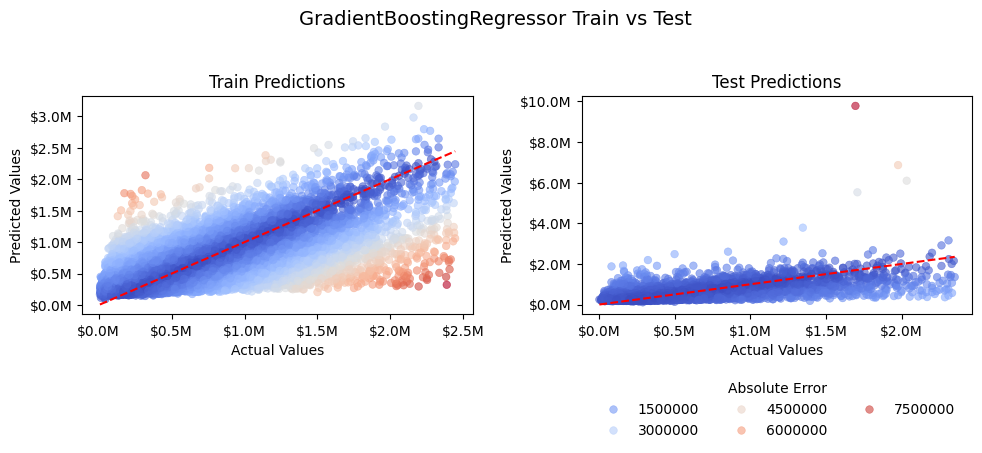

,model,model_params,mean_CV_RMSE,std_CV_RMSE,training_RMSE,test_RMSE,run_comment
0,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",402411.856021,35735.385117,320831.030798,366895.239024,Best Model Final Run: 'GBT Fine-Tuning No Log ...


In [56]:
run_model(
          model=GradientBoostingRegressor,
          X_train=feature_engineering_X_train_no_log,
          y_train=feature_engineering_y_train_no_log,
          X_test=feature_engineering_X_test_no_log,
          y_test=feature_engineering_y_test_no_log,
          n_repeats=5,
          n_jobs=-1, 
          concat_results=False,
          run_comment="Best Model Final Run: 'GBT Fine-Tuning No Log Final'", 
          target_is_logged=False,
          plot_pred=True, 
          **GBT_best_params
          )

____

___

Upload Figure Example

![Test_Figure_1](./Figures/Test_Figure_1.png)

____

## Part B: Final Data Science Project Report Assignment [30 pts]

This final report is the culmination of your semester-long Data Science project, building upon the exploratory analyses and modeling milestones you've already completed. Your report should clearly communicate your findings, analysis approach, and conclusions to a technical audience. The following structure and guidelines, informed by best practices, will help you prepare a professional and comprehensive document.

### Required Sections

Your report must include the following sections:


___

#### **1. Executive Summary (Abstract) [2 pts]**
- **Brief overview of the entire project (150–200 words)**
- **Clearly state the objective, approach, and key findings**

TODO: I wonder if the key findings should be *after* our changes here? aka re-do the last paragraph when done? 

**Rough Draft w/ TaxValue** The goal of this project is to develop a predictive model using Zillow’s housing dataset to estimate the tax-assessed value of residential properties (taxvaluedollarcnt). By leveraging various home features—such as square footage, location, and year built—the model aims to build on the success of Zillow’s widely-used Zestimate tool by expanding its capabilities to include predictions of a home’s tax-assessed value. This would offer homeowners greater transparency into how their property taxes—one of the most significant ongoing expenses after purchasing a home—are determined.


Our approach is to apply regression techniques to identify key factors influencing property valuations, build a model to predict the taxvaluedollarcnt of different properties based on the data provided by Zillow, and to minimize prediction errors, as evaluated by the use of metrics like Root Mean Squared Error (RMSE). 

Our key findings were that while ensemble methods like Gradient Boosted Trees yielded RMSEs that were improvements over baseline estimates, models still contained an average error rate north of \$300,000. Due to the trend of models performing significantly worse on homes with taxvalluedollarcnt over \$2,000,000, (consistently undershooting targets) we suspect that this 'average' is doing significantly worse due to the presence of extreme outliers in the data (some close to \$49,000,000). 

___

#### **2. Introduction [2 pts]**
- **Clearly introduce the topic and context of your project**
- **Describe the problem you are addressing (the problem statement)**
- **Clearly state the objectives and goals of your analysis**

Note: You may imaginatively consider this project as taking place in a real estate company with a small data science group in-house, and write your introduction from this point of view (don't worry about verisimilitude to an actual company!).  

TODO: There was a bunch of talk in the live session about it being the taxvalue and not the market value, and that we should humor them and preted that we're pitching this in some way -- so let me know what you think

**Rough Draft** 

Released 15 years ago, Zillow’s **Zestimate** feature revolutionized transparency in the real estate sector by giving home buyers instant access to accurate, market-based property valuations -- allowing consumers to  easily compare listing prices to market estimates with just a click. 

But while this market value is critical during the initial real estate transaction, there is another metric that impacts the finances of homeowners long after the initial purchase, and that is the **tax assessed value**. 

Yet despite property taxes represent one of the largest ongoing costs for homeowners across the nation, many homeowners have little visibility into how this value is determined, or whether their value is fair when compared to similar properties. 

As part of our in-house data science initiative, we aim to address this gap by leveraging machine learning to develop a model that accurately predicts a property's tax assessed value. In this, our main objectives were clear: 

- Identify the most important features when assessing a home's tax value. 

- Develop a machine learning model to accurately predict a home's tax assessed value from zillow's database. 
 



___

#### **3. Data Description [2 pts]**
- **Describe the source of your dataset (described in Milestone 1)**
- **Clearly state the characteristics of your data (size, types of features, missing values, target, etc.)**

**Data Set Source**

The dataset was sourced from Zillow’s 2017 Kaggle competition *Zestimate Prediction* (Zillow Prize).  
It was provided already reduced to **77,613 rows** and **55 columns** for this project.  
Unlike the original competition, our **target variable** is the **assessed tax value** of properties (`taxvaluedollarcnt`), not the sale price estimate.

---

**Dataset Characteristics**

- **Size**: 77,613 rows × 55 columns (before cleaning).

- **Features**:
  - A mix of **numerical** and **categorical** features.
  - Several fields are **ID-like numeric references** (e.g., `propertylandusetypeid`, `airconditioningtypeid`) pointing to external master data, but no official mappings were initially provided by BU.
  - To improve clarity and interpretation, the original mappings were retrieved from the **published Zillow Kaggle source**, and dictionaries were created to meaningfully encode these features during data preparation.

- **Target Variable**:  
  `taxvaluedollarcnt` — the total tax-assessed value of each property (continuous numerical feature).

- **Missing Values**:
  - Several features had over 90% missing values.
  - Columns missing more than 60% of their values or without usable mappings were dropped.
  - At a later stage, some features (e.g., `fireplaceflag`) were processed into binary flags rather than discarded.

- **Duplicate Records**:
  - **199 duplicate rows** were identified based on the `parcelid` (property ID) and removed during data cleaning.

- **Outliers**:
  - Extreme outliers in the target variable were detected and removed using the IQR method to improve modeling stability.

- **Dropped Features**:
  After analyzing the dataset, the following fields were dropped:
  - **Columns with excessive missing values**:  
    Samples missing more than 60% of their values were dropped as they lacked sufficient information for analysis or modeling.
  - **Samples with missing target values**:  
    Rows missing the target variable were removed, as they could not contribute meaningfully to supervised learning.
  - **Extreme outliers**:  
    Samples with extreme outlier target values were removed using the IQR method.
  - **Irrelevant or Uninterpretable Features**:  
    Some fields were flagged as irrelevant for modeling purposes. Examples include:
    - `parcelid` (unique identifier, not predictive)
    - `latitude` and `longitude` (too granular for this modeling scope)
    - `regionidcity`, `regionidzip`, and `regionidneighborhood` (geographic codes not aligned with analysis)
    - `assessmentyear` (only one unique value: 2016)
    - `rawcensustractandblock` and `censustractandblock` (sparse, unprocessed census identifiers)

---

**Categorical Features**

Further analysis identified a set of features that are explicitly categorical, examples include:

- `hashottuborspa`
- `propertycountylandusecode`
- `propertyzoningdesc`
- `fireplaceflag`
- `taxdelinquencyflag`

Additionally, several numeric-coded fields were recognized as **categorical enumerations**.  
To improve interpretability, these fields were mapped to their corresponding category names based on Zillow’s original Kaggle dataset (reference 1). Key examples include:

- `HeatingOrSystemTypeID`
- `PropertyLandUseTypeID`
- `StoryTypeID`
- `AirConditioningTypeID`
- `ArchitecturalStyleTypeID`
- `TypeConstructionTypeID`
- `BuildingClassTypeID`

---

**Overall**, the dataset contains a diverse mix of structural, financial, and geographic features. Most features are numerical, while a significant subset are categorical fields that required additional decoding to enhance their meaning for predictive modeling.


____

#### 4. Methodology (What you did, and why)  [12 pts]

**Focus this section entirely on the steps you took and your reasoning behind them. Emphasize the process and decision-making, not the results themselves**


**A. Clearly outline your data cleaning and preprocessing steps**
  - Describe what issues you encountered in the raw data and how you addressed them.
  - Mention any key decisions (e.g., removing samples with too many missing values).
  - What worked and what didn't work?

**B. Describe your feature engineering approach**
  - Explain any transformations, combinations, or derived features.
  - Discuss why certain features were chosen or created, even if they were later discarded.
  - What worked and what didn't work?

**C. Describe your analytical framework**
  - Use of validation curves to see the effect of various hyperparameter choices, and
  - Choice of RMSE as primary error metric

**D. Detail your model selection process**
  - Outline the models you experimented with and why.
  - Discuss how you evaluated generalization (e.g., cross-validation, shape and relationships of plots).
  - Mention how you tuned hyperparameters or selected the final model.



____

**4.A. Data Cleaning and Preprocessing**

The first step that we took was to do a preliminary dataset analysis. The main point of this excercise was to get a handle on the different features of the dataset, their structure, if there were a large number of null values, (basically is a feature useable or not) and whether each field had a large degree of outliers. Some quick references to this work are here: 

In [35]:
# Box plots from part 1? or something interesting

In [36]:
# Missing Value Counts

From there, we immediately flagged certain features for removal due to having more than 90% null or missing values. However, instead of dropping some variables outright, we agreed as a team to flag specific fields for potential consolidation. For example, 'fireplacecnt' and 'fireplaceflag' both of which were incomplete on their own and displayed instanced where one of them was null and the other was not, could be combined into a single binary flag, such as fireplaceflag_new. Although each of these fields appeared incomplete individually, we believed they could still provide meaningful information contributing to the overall tax value of the home, and therefore be useful for modeling in some capacity.

Dropped Features with ≥ 90% Missing Values:

- buildingclasstypeid (99.98% missing, numeric)
- finishedsquarefeet6 (99.5% missing, numeric)
- finishedsquarefeet13 (99.95% missing, numeric)
- finishedsquarefeet15 (96.1% missing, numeric)
- finishedsquarefeet50 (92.22% missing, numeric)
- storytypeid (99.94% missing, numeric)
- architecturalstyletypeid (99.73% missing, numeric)
- typeconstructiontypeid (99.71% missing, numeric)
- decktypeid (99.21% missing, numeric)
- taxdelinquencyflag (96.26% missing, categorical)
- taxdelinquencyyear (96.26% missing, numeric)
- finishedfloor1squarefeet (92.22% missing, numeric)

Dropped Features with ≥ 60% Missing Values (Deemed Not Useful for Regression):
- threequarterbathnbr (86.98% missing, numeric)
- numberofstories (77.32% missing, numeric)
- regionidneighborhood (60.09% missing, numeric)

We removed features with extremely high percentages of missing data because their lack of completeness compromised their reliability, making them unsuitable for predictive modeling. Columns with ≥90% missing values—such as various square footage measures and identifiers like buildingclasstypeid—lacked sufficient data to offer meaningful insights. Additionally, features with 60% or more missing values, like threequarterbathnbr and numberofstories, were excluded when they provided little value to our regression task. By eliminating these columns, we aimed to reduce noise and potential bias, ensuring that our models are trained on a more robust and complete dataset.


In [37]:
# potential display? 

#  Null threshold: 60.0%

Next, we looked into records that had null values for the target variable, we figured in this case, that no matter what these records were useless for modeling so they were dropped. 

In [38]:
# Number of samples before dropping null values in the target: 77,613
# Number of samples after dropping null values in the target: 77,578
# Number of samples before dropping too many null values in the target: 77,578
# Number of samples before dropping too many null values in the target: 77,274

**4.B. Feature Engineering**

In [39]:
# Final Feature Engineering Choices from Milestone 2 part 2? 

**4.C. Describe your Analytical Framework**
  - Use of validation curves to see the effect of various hyperparameter choices, and
  - Choice of RMSE as primary error metric

Before proceeding further, we want to clarify that Root Mean Squared Error (RMSE) was used as the primary evaluation metric throughout this analysis. This choice was driven by one key consideration: RMSE is expressed in the same units as the target variable. This makes it an intuitive and meaningful measure of model performance for predicting our target, tax assessed value, in this context -- allowing us to say: 'our predictions are off by 'x' amount on average.'

Additionally, given that this model is intended to be a client-facing feature, accuracy becomes even more critical. Clients would likely be dissatisfied if our predictions of their home’s tax assessed value deviate significantly from the actual value. In this context, the difference between predicted and actual values is effectively captured by RMSE. As such, RMSE represents the key source of error we aim to minimize, and it serves as the primary benchmark by which our model’s performance will be evaluated once deployed in production.



Going into hyperparameter tuning, our MEAN CV RMSE's were as follows: 

In [40]:
# Insert Graph from part 3

As such our top performing models going into the hyper parameter tuning section of model development were: 

- Gradient boosted trees with features from Part 2.2 -- no log transformation / RMSE: 402,691
- Random Forest Regression with featuers from Part 2.2 -- no log transformation / RMSE: 410,873
- Linear Regression with Final Features from Part 3 / RMSE: 411,238

For each of these models, the most 'influential' feautres were determined for each using model documentation and Boston Univeristy materials on the issue. From there, parameter sweeps were set up to first test a broad range of possible values for hyperparameters, and results were plotted for the mean CV for each of the hyperparameters. 

From there, we used the plots in the first parameter sweeps to either: a) determine a second parameter sweep (if necessary) using curtailed ranges in order to zero in on the best possible range, or b) determine a final range to test for each hyperparameter using Gridsearch Cross Validation. The results are as follows: 

**Gradient Boosted Trees**

In [41]:
# Gradient Boosting Trees Hyperparameters

In [42]:
# Important updates

In [43]:
# Final Gridsearch and Results

**Random Forest**

In [44]:
# First parameter sweep results

In [45]:
# Updated ranges if needed results

In [46]:
# Gridsearch CV and Results

**Linear Regression**

In [47]:
# First parameter sweep results

In [48]:
# Updated ranges if needed results

In [49]:
# Gridsearch CV and Results

**4.D. Detail your model selection process**
  - Outline the models you experimented with and why.
  - Discuss how you evaluated generalization (e.g., cross-validation, shape and relationships of plots).
  - Mention how you tuned hyperparameters or selected the final model.

At the beginning of Part 2, we developed a function called run_model(), which was used throughout the project to consistently evaluate model performance across different stages. The output of run_model() included:

- An updated global output DataFrame that recorded results each time the function was executed, allowing us to track progress across multiple tests.
- An optional plot comparing actual vs. predicted values for each model, enhanced with a heatmap to visualize how closely points aligned with the ideal prediction line.

In [50]:
# Output dataframe

These visualizations helped us assess model behavior, particularly in identifying signs of overfitting and understanding performances across different ranges of the target variable. For example, some models predicted lower-value targets accurately but struggled with higher-value predictions, especially when the target variable exceeded $2 million.

Additionally, run_model() tracked Root Mean Squared Error (RMSE) at three key stages:
- Training RMSE
- Cross-Validation RMSE using 5-fold, 5-repeat cross-validation
- Test Set RMSE (utlilized at the end of all tests)

As an a side note, for cases where the target variable was log-transformed, we implemented a parameter within run_model() to handle this scenario. The function applied cross-validation in log space and then inverse-transformed the predictions to calculate RMSE in the original scale. This approach ensured consistency and leveraged KFold to properly simulate repeated cross validation. 

At the conclusion of each phase — whether baseline testing, feature engineering, or feature selection — we plotted the Training RMSE against the Cross-Validation RMSE for all candidate models. This allowed us to visually compare performance and detect potential overfitting by observing discrepancies between training and validation errors.



In [51]:
# Example of RMSE plot for baseline models

Finally, after completing feature selection, we identified the top-performing models for hyperparameter tuning based on their performance and generalization capability. The selected models were:

- Gradient Boosted Trees with full features and no log transformation
- Random Forest with full features and no log transformation
- Linear Regression with selected features and no log transformation

These models demonstrated the best balance between accuracy and robustness, making them strong candidates for further optimization.

Starting with each of the top three models, the four 'most influencial' hyperparamters were chosen based on documentation and Boston University resources. **(Need reference)**. For the **gradient boosted Trees** model these were: 

- **learning_rate** - (impact of each tree on learning  (typicall 0 - 1); lower values indicate slower learning)
- **n_estimators** - (Essentially how many trees (in this case boosting stages) are used)
- **max_depth** - (Limits how deep each tree can grow)
- **max_features** - (How many features are considered at each split)

For the **Random Forest** model they were: 
- **n_estimators** - (Essentially, how many trees are used)
- **max_features** - (How many feautures are considered for each split)
- **max_depth** - (How deep each tree can grow)
- **booststrap** - (Is bootstrapping used (T/F))

Finally, the **Linear Regression** model didn’t offer many hyperparameters to tune, but the two we could adjust were:
- **fit_intercepts** (Force the model to go through the origin if False (T/F))
- **positive** (Force the model to only have positive coefficients if True (T/F))


The details of our specific hyperparameter choices are outlined in Part 4.C. In general, we used the full-feature, no-log dataset for training, as our top-performing models consistently achieved the best results on this dataset, and we aimed to maintain standardization across tests.

We began by defining broad initial ranges for each hyperparameter to observe their impact on RMSE cross-validation scores. Based on these results, we refined our search by conducting a second parameter sweep to “hone in” on ranges that showed promising behavior. Finally, we used these insights to define a focused range of values for a GridSearchCV to fine-tune the models.

Once we finalized the hyperparameter selections for each model, we conducted final tests using three datasets:
	1.	The no-log full-feature dataset,
	2.	The logged-target dataset, and
	3.	The dataset with selected features from feature selection.

We compared the performance of these tuned models against all prior runs—from baseline models to those with feature engineering and so on — to identify the overall best-performing model.


__

**Graveyard**
For each of these, an initial parameter sweep was set up to test wide ranges for each of the initial parameters. Our initial ranges were as follows: 

- **n_estimators:** -- Set up an initial range of (100 - 500 estimators). The default number of estimators for both the random forest and the gradient boosted trees models were 100 estimators, so this is to test if there is a significant impact to increasing the number of estimators to a large degree. IF this did not prove true (or if the curve was just flat) then a second range from 1 - 100 was proposed to see if there was a significant impact on *decreasing* the overall number of estimators. 

- **learning_rate** -- This hyperparameter was only on the boosted tree set. We initially set up an initial test of 0.05, 0.1, 0.25, 0.5, 0.75, 1.0 and realized that we got a relatively flat performance curve, with a 'best' value on the lower end of the curve. A second sweep was set up to test the lower end of the range with 0.01, 0.05, 0.1, 0.2, 0.3 being the possible values. At this point we got a 'best' value of around 0.1, so gridsearch CV was setup to test 0.09, 0.1, 0.11, 0.12, and 0.13 for the final test. 

- **max_depth** - An initial run of 1 - the max features was set up to 

____

#### 5. Results and Evaluation (What you found, and how well it worked) [10 pts]

**Focus purely on outcomes, with metrics, visuals, and insights. This is where you present evidence to support your conclusions.**

- Provide a clear and detailed narrative of your analysis and reasoning using the analytical approach described in (4). 
- Discuss model performance metrics and results (RMSE, R2, etc.)
- **Include relevant visualizations (graphs, charts, tables) with appropriate labels and captions**
- Error analysis
  - Highlight specific patterns of error, outliers, or questionable features.
  - Note anything surprising or worth improving in future iterations.


____

#### 6. Conclusion [2 pts]
- Clearly state your main findings and how they address your original objectives
- Highlight the business or practical implications of your findings 
- Discuss the limitations and constraints of your analysis clearly and transparently
- Suggest potential improvements or future directions

___

## **References**  
1. Kaggle. (2017). Zillow Prize: Zillow’s Home Value Prediction (Zestimate) [Dataset]. Kaggle. https://www.kaggle.com/competitions/zillow-prize-1/data

2. McFarling, L., Zonglin W., & Nelyapenko S. (2024). *Module 3 Milestone 1 [Data analysis notebook]*. GitHub. [https://github.com/LeeMcFarling/Module_3_Milestone_1](https://github.com/LeeMcFarling/Module_3_Milestone_1)

3. McFarling, L., Zonglin W., & Nelyapenko S. (2024). *Module 3 Milestone 2 [Data analysis notebook]*. GitHub. [https://github.com/LeeMcFarling/Module_3_Milestone_1](https://github.com/LeeMcFarling/Module_3_Milestone_2)

4. McFarling, L., Zonglin W., & Nelyapenko S. (2024). *Module 3 Final_Project [Data analysis notebook]*. GitHub. [https://github.com/LeeMcFarling/Final_Project_Writeup](https://github.com/LeeMcFarling/Final_Project_Writeup)

